In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# PriorVAE: comparing different loss functions - visualisation of ARC training

**Current issue**: the decoder weights are v. close to zero (but non-zero, ish)

For a 1D GP

In [9]:
from jax import random
import jax.numpy as jnp

import time
import dill
from flax import serialization

# Numpyro
import numpyro
from numpyro.infer import MCMC, NUTS, init_to_median, Predictive


In [10]:
numpyro.set_host_device_count(3)

In [12]:
# OLD ONES
#path = "./learnt_models/04_1000_batches_gpu_args.dill" # 100 epo,  batch 400   500 batches - compares rcl_kld_50mmd, kld_50mmd, rcl_kld 
#path = "./learnt_models/04_args_150_cpu.dill"          # 50 epo    batch=200   500 batches - compares 'rcl_kld', 'rcl_kld_50mmd_rbf', 'kld_mmd_rbf', 'kld_50mmd_rbf', 'kld_mmd_rbf_ls_1_2_4_16_32', 'kld_mmd_rq', 'kld_50mmd_rq
#path = "./learnt_models/04_args_150_epochs.dill"        # above with 150 epochs
#path = "./learnt_models/04_args_400_batchsize.dill"     # 100 epo,  batch 400   500 batches - compares rcl_kld_50mmd, kld_50mmd, rcl_kld AGAIN
#path = "./learnt_models/04_args_epo100_batchsize400.dill" #
#path = "./learnt_models/04_args_full_comp_50.dill"      # 50 epo    batch 200   500 batches - compares full 1st set:'rcl_kld', 'rcl_kld_50mmd_rbf', 'kld_mmd_rbf', 'kld_50mmd_rbf', 'kld_mmd_rbf_ls_1_2_4_16_32', 'kld_mmd_rq', 'kld_50mmd_rq'

#   GOOD COMPARISONS, note losses are now normalised!
path = "./learnt_models/04/04_args_scaling_mmd_tests.args"    # 150 - 200 - 500, scaling factors on mmd_rbf & mmd_rq, including RCL terms, which damages variance/higher moments
#path = "./learnt_models/04/04_args_without_rcl.args"           # 150 - 200 - 500, scaling factors on mmd_rbf & mmd_rq, without RCL, 
#path = "./learnt_models/04_args_long_runs_on_best06.dill" # chose the best column from first 06 run (06_args_mmd_rbf-rcl_scaling), though 2nd one ran out of time
#path = "" # search grid on 

with open(path, "rb") as f:
    args = dill.load(f)

print(args["loss_functions"])


['rcl_kld_1mmd_rbf', 'rcl_kld_5mmd_rbf', 'rcl_kld_10mmd_rbf', 'rcl_kld_25mmd_rbf', 'rcl_kld_50mmd_rbf', 'rcl_kld_100mmd_rbf', 'rcl_kld_1mmd_rq', 'rcl_kld_5mmd_rq', 'rcl_kld_10mmd_rq', 'rcl_kld_25mmd_rq', 'rcl_kld_50mmd_rq', 'rcl_kld_100mmd_rq']


(150,)


/home/max/4yp/plotting/plots.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


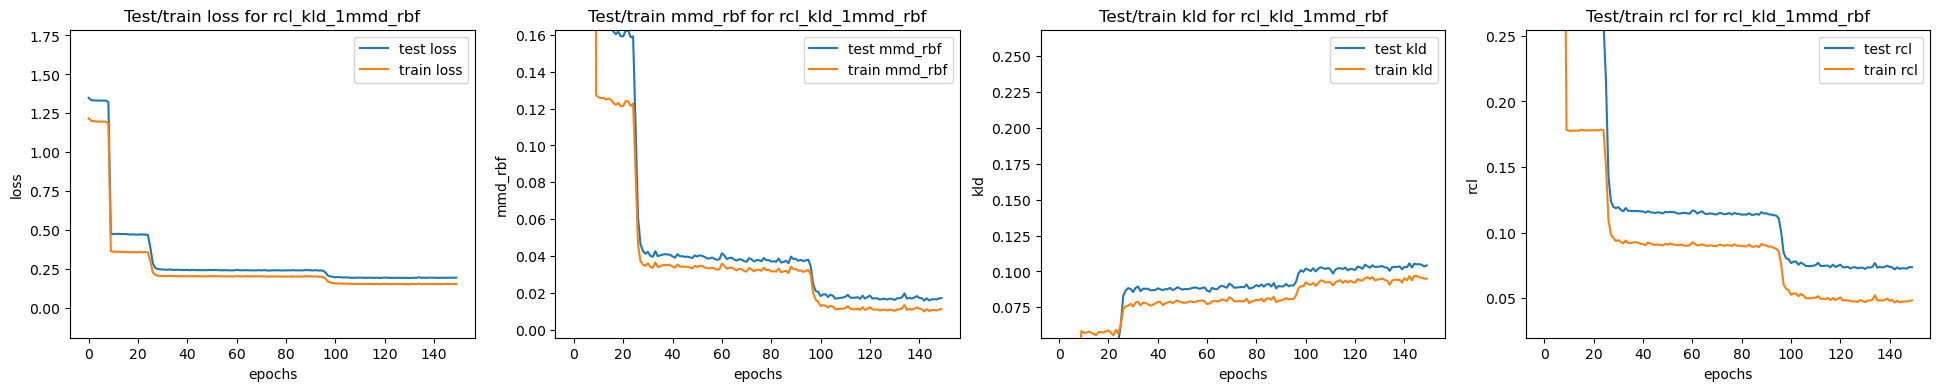

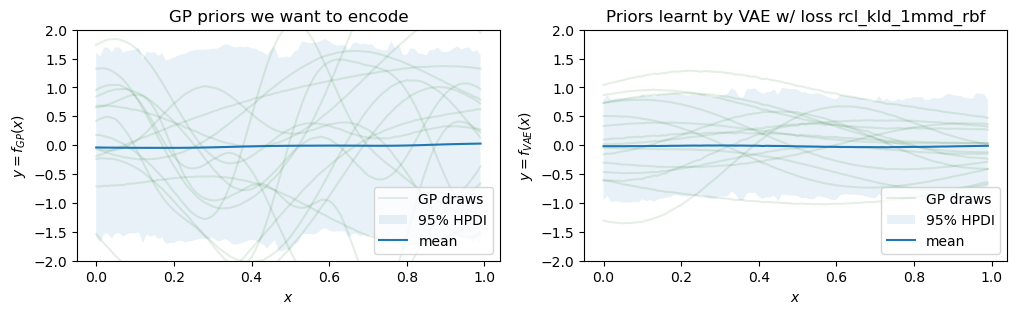

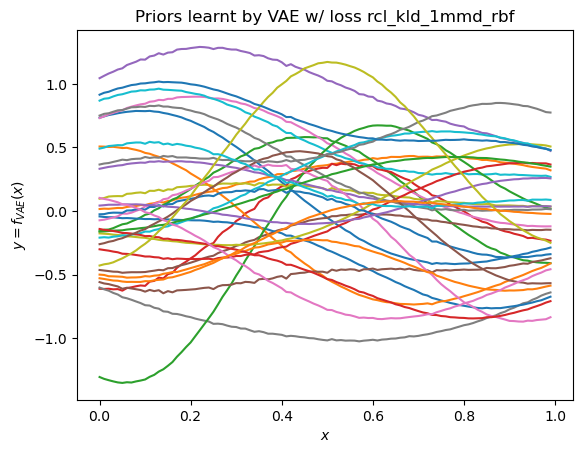

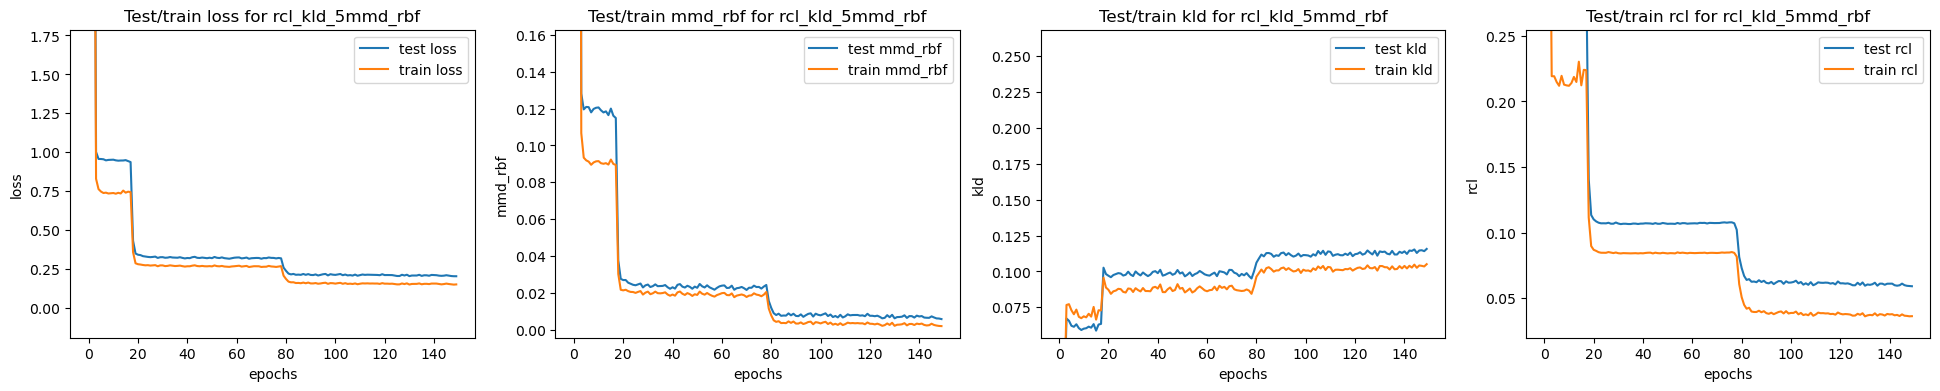

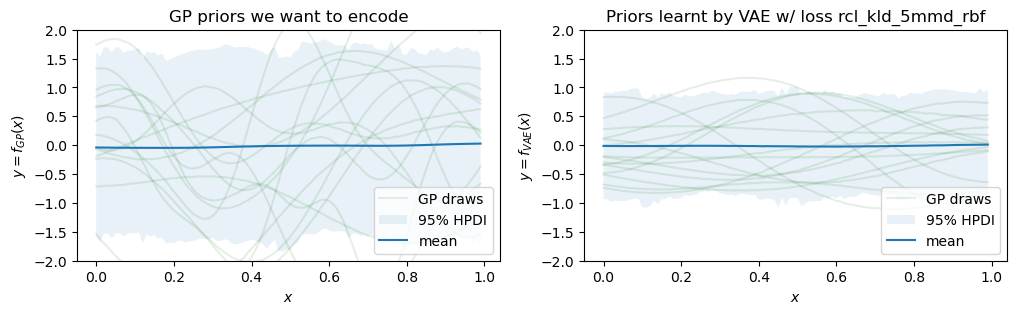

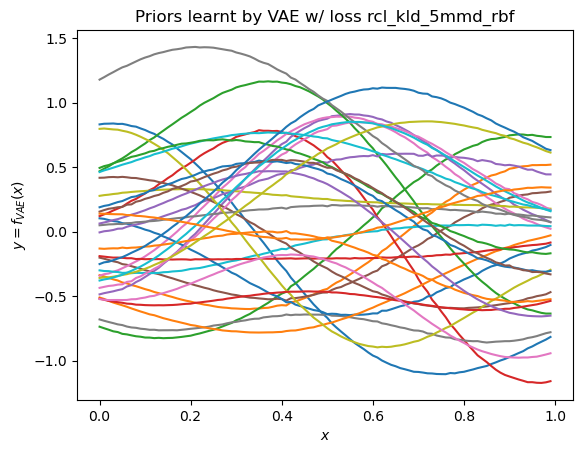

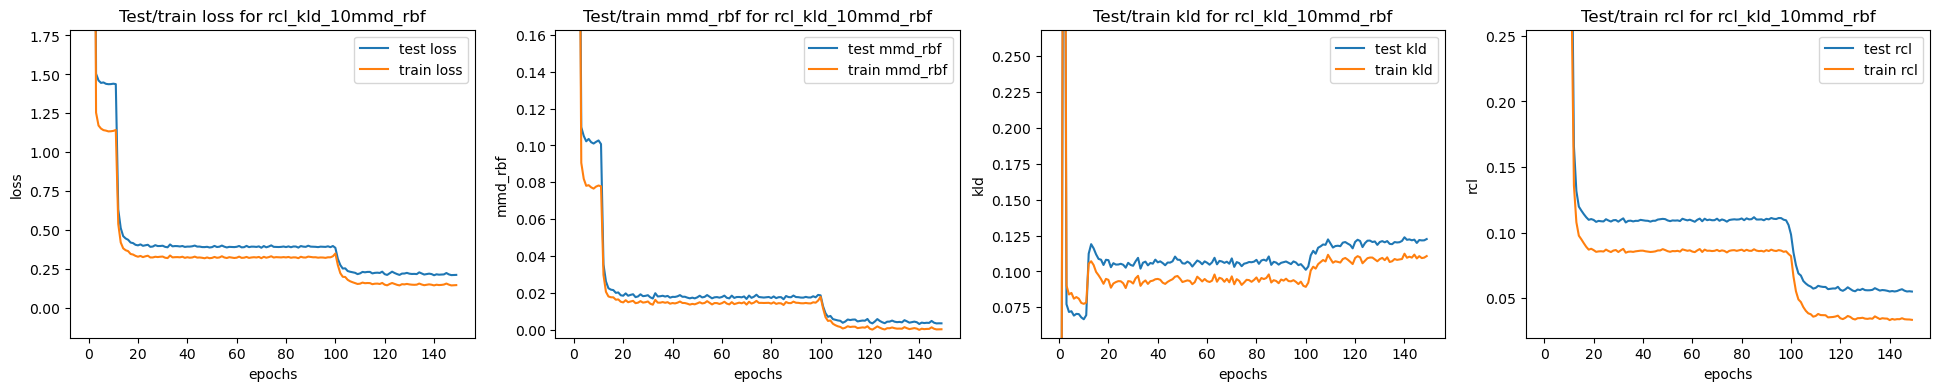

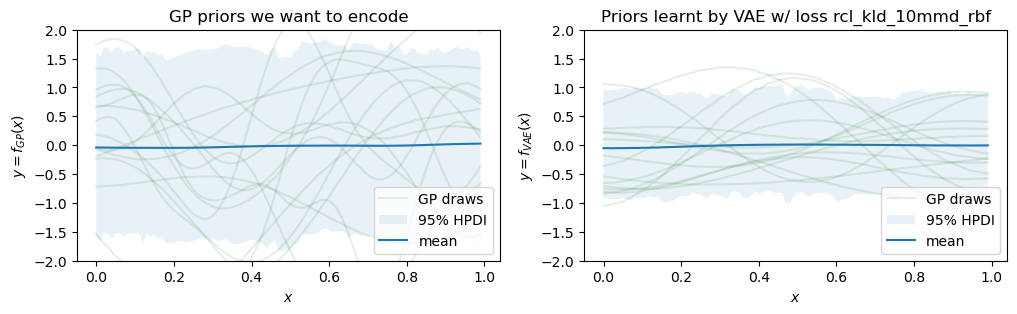

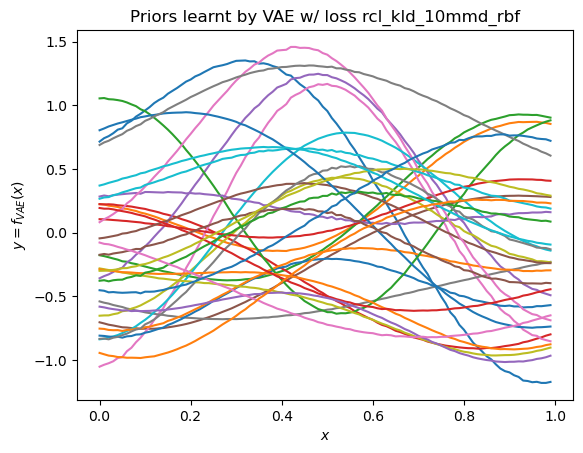

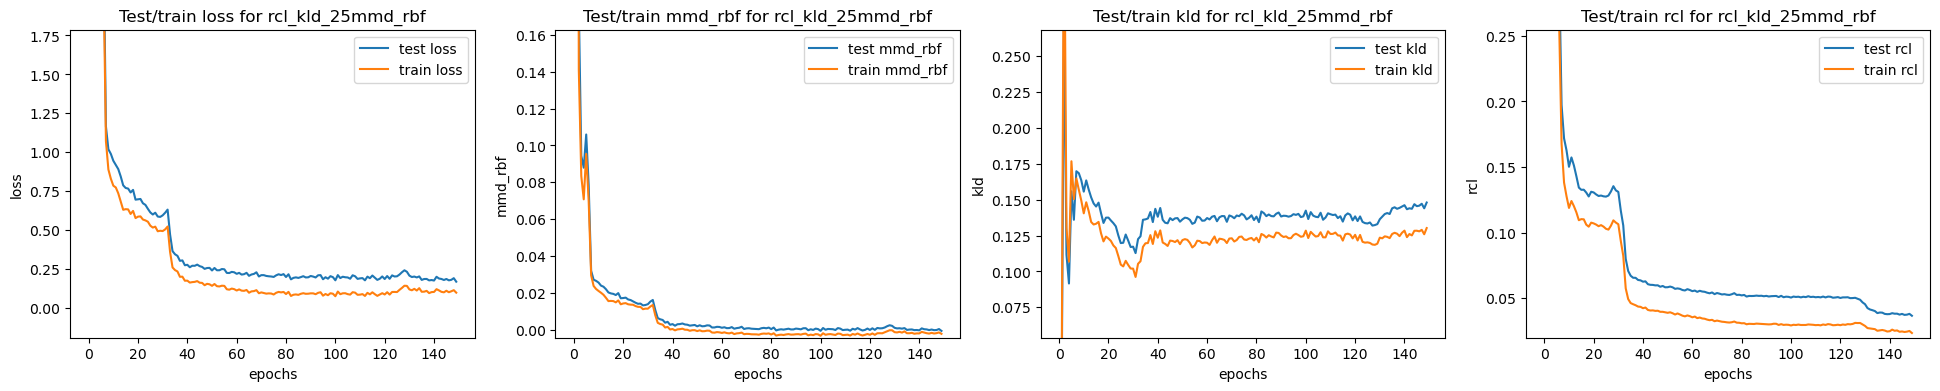

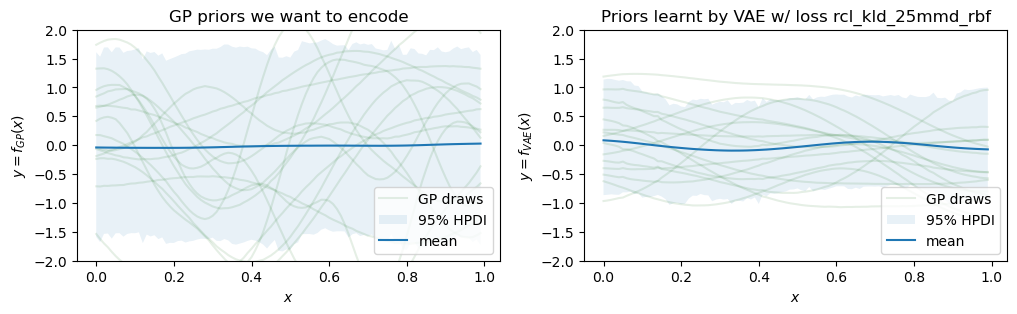

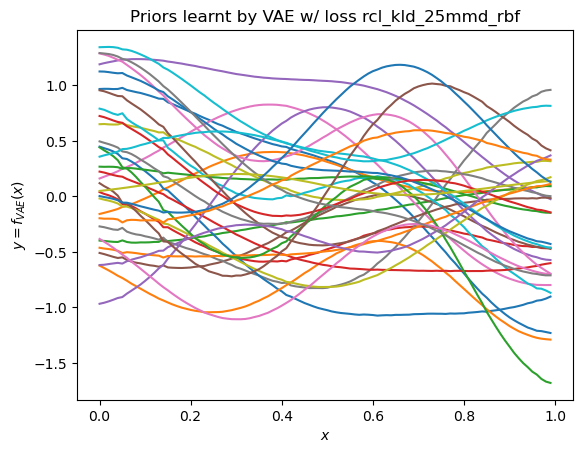

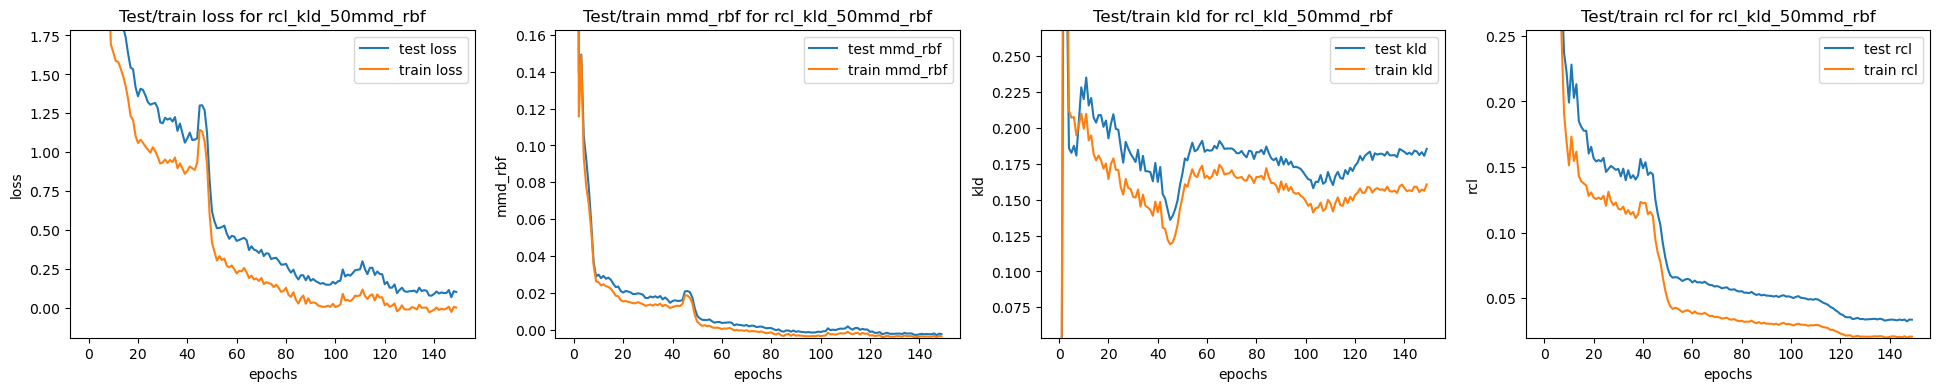

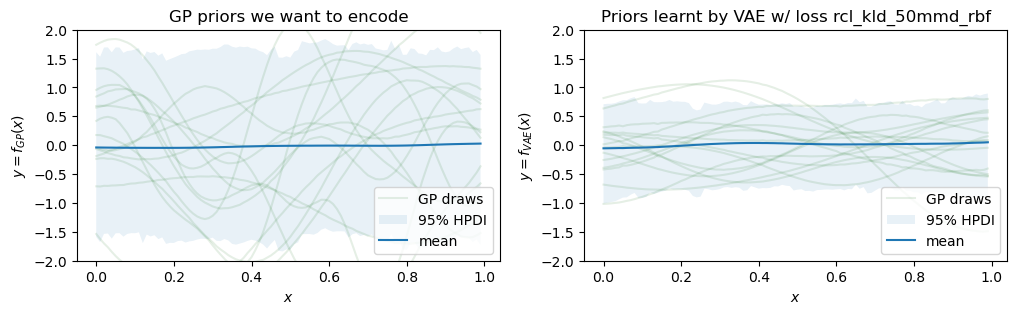

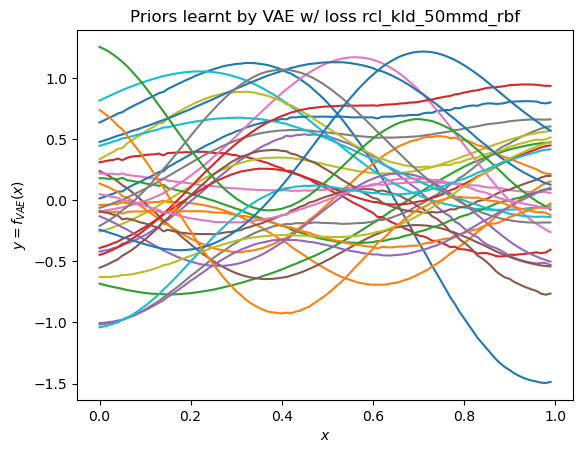

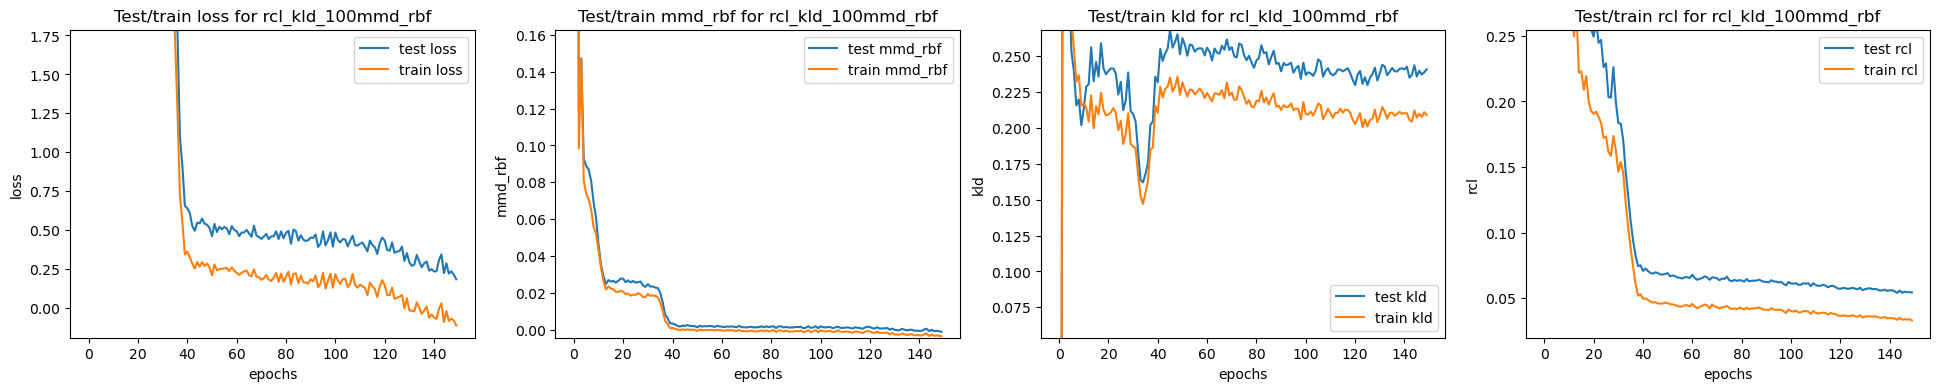

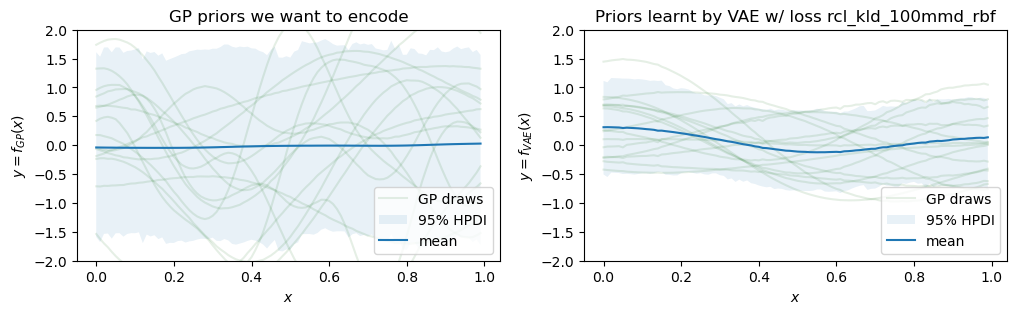

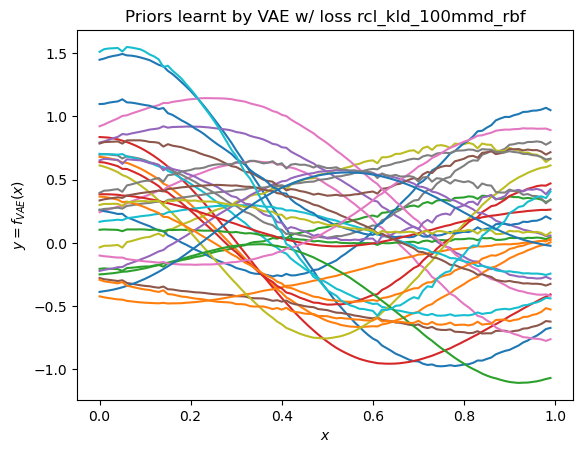

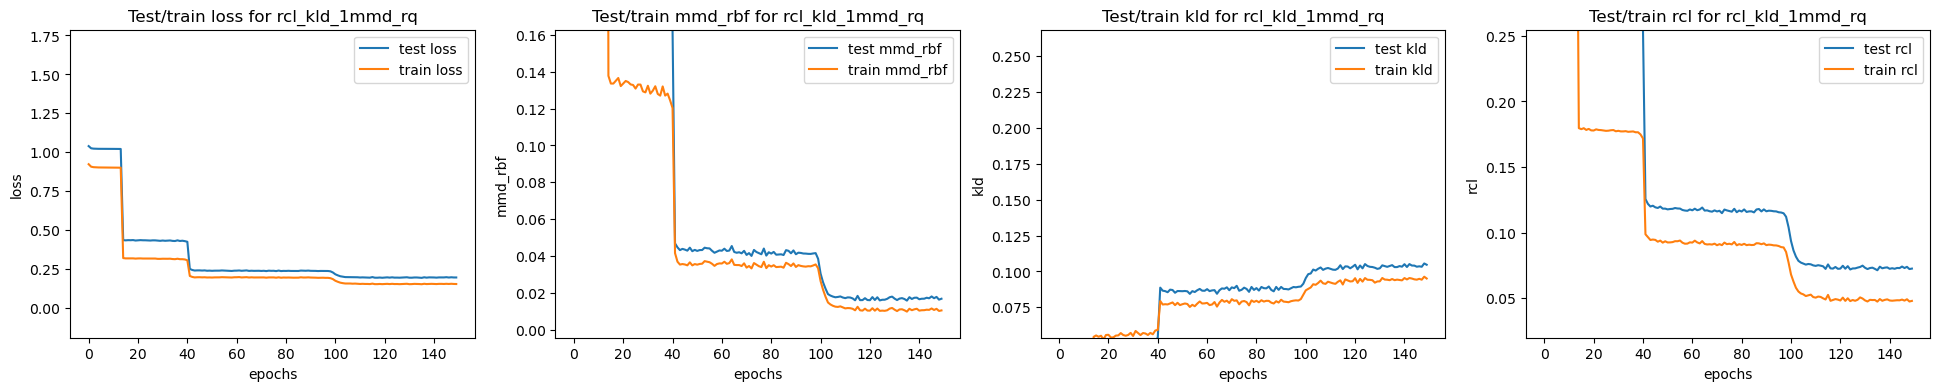

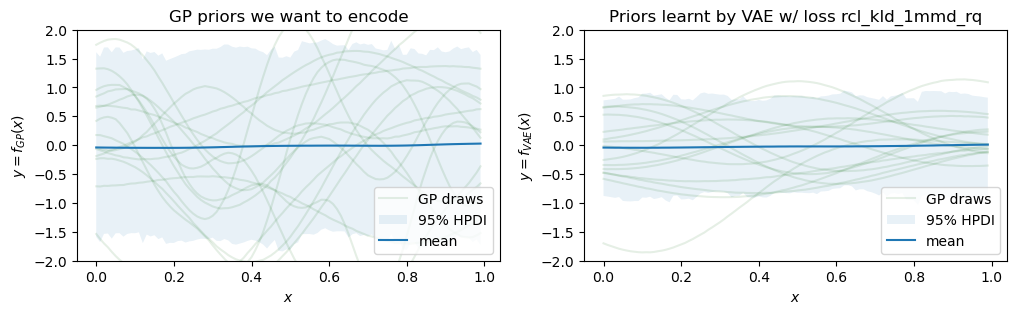

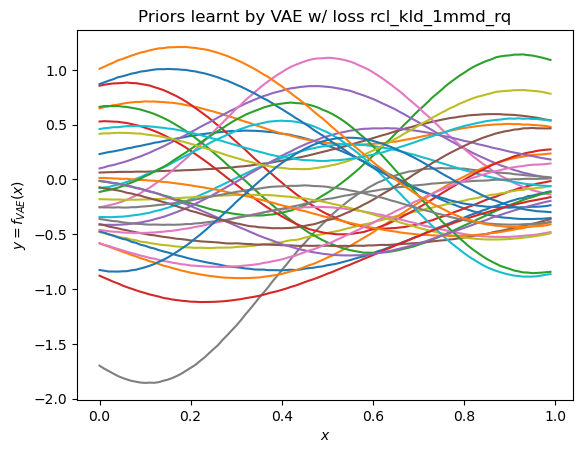

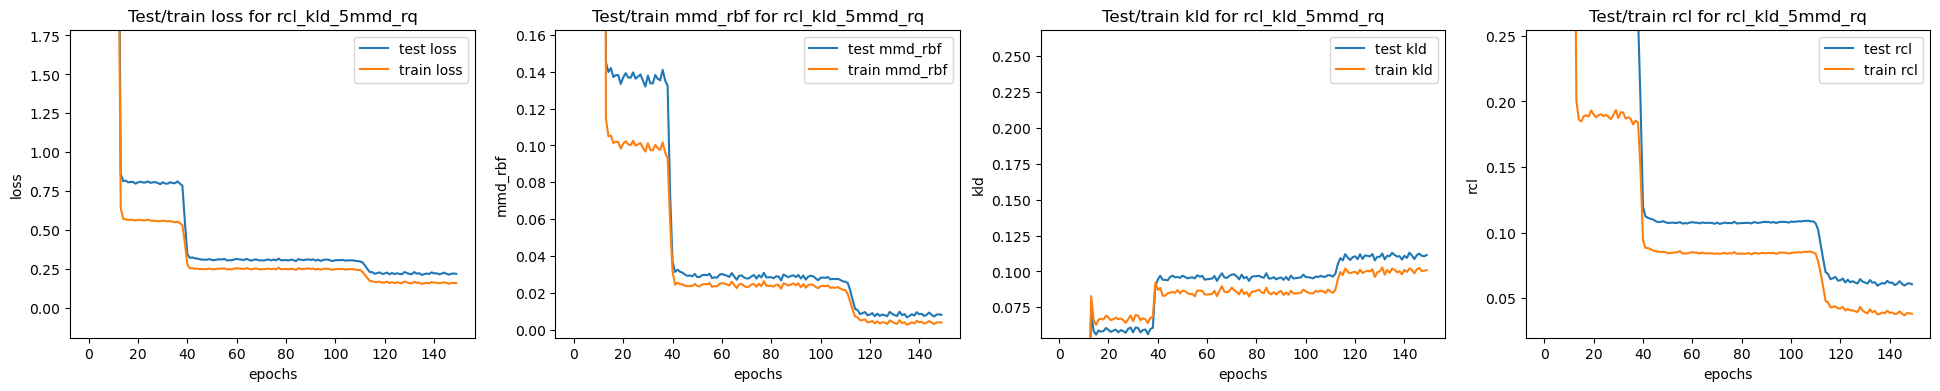

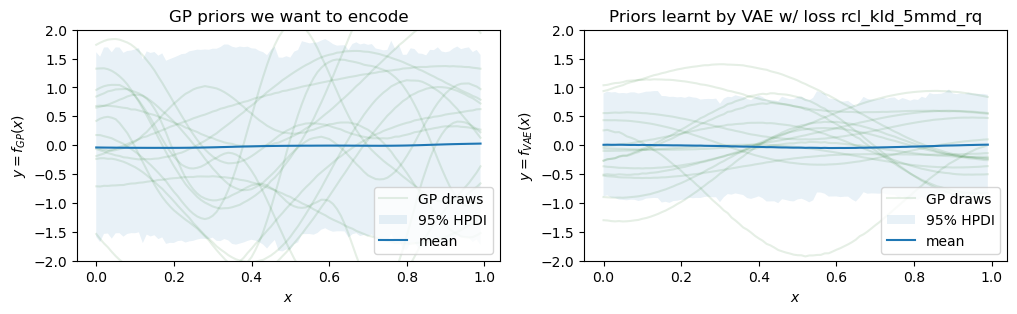

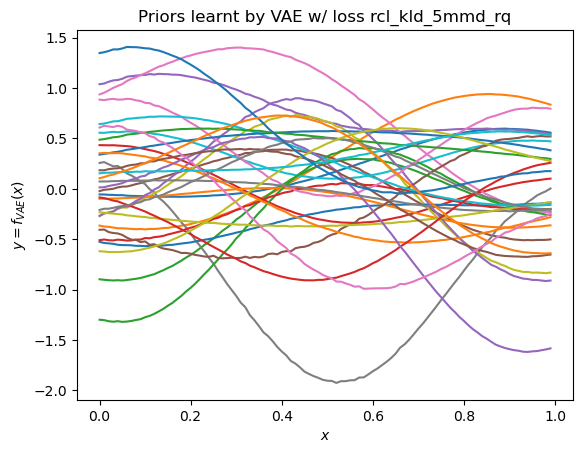

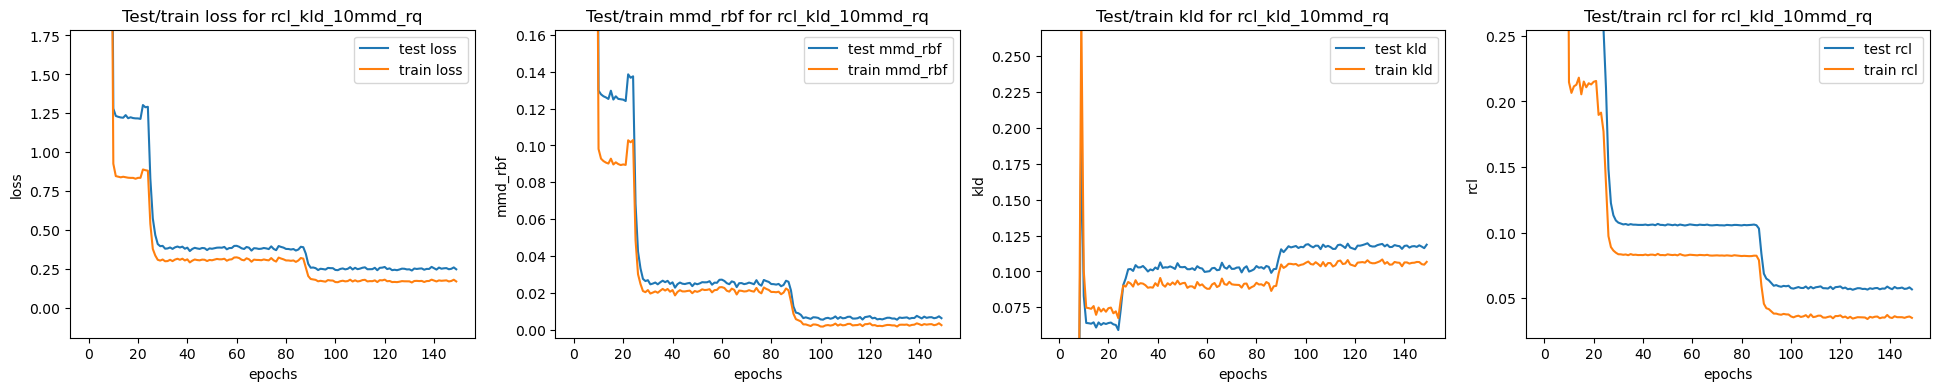

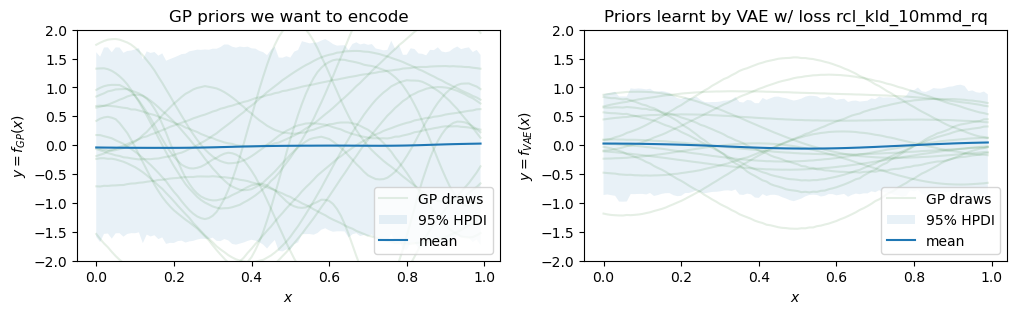

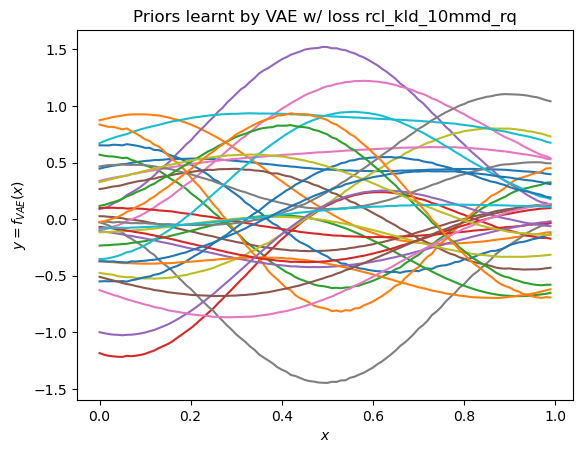

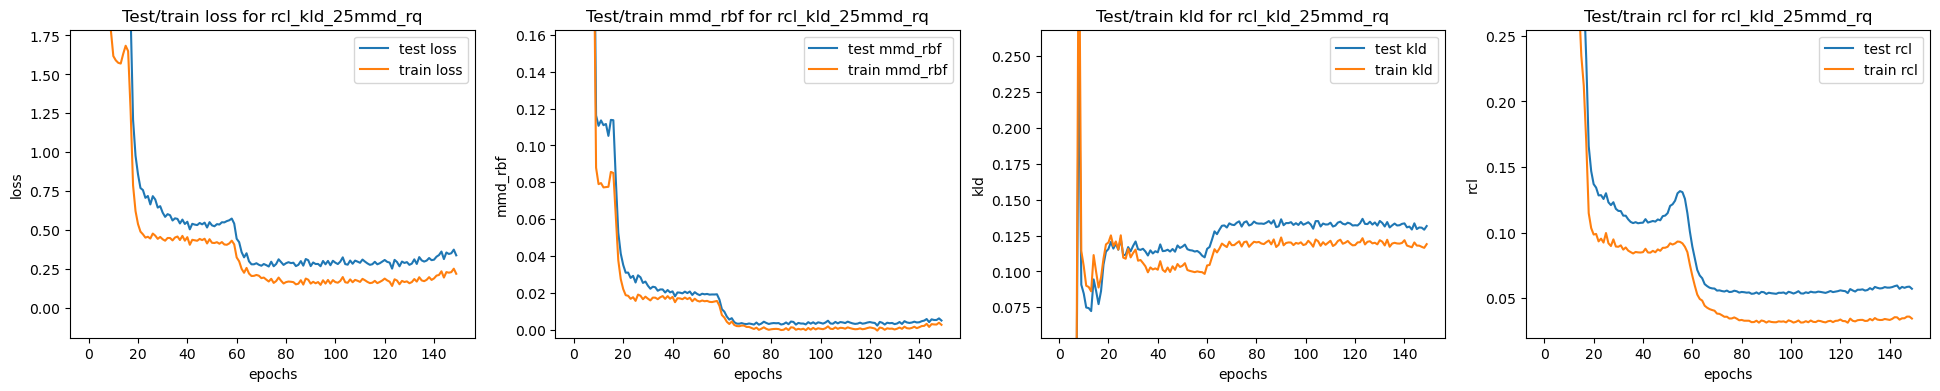

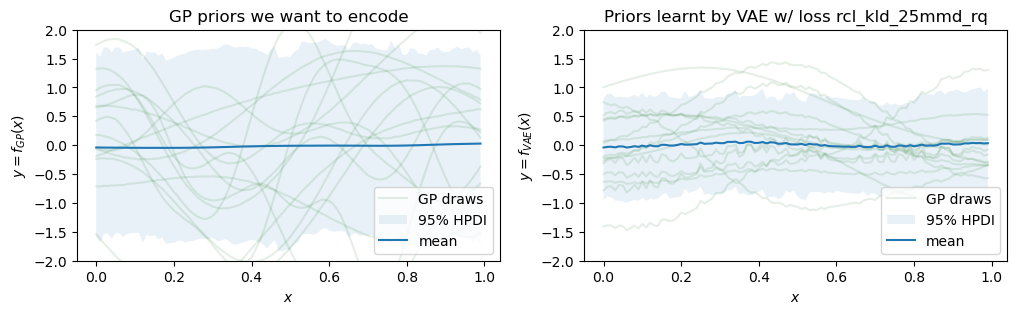

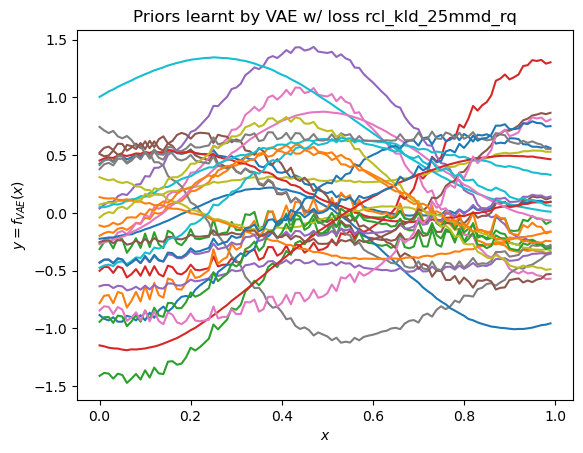

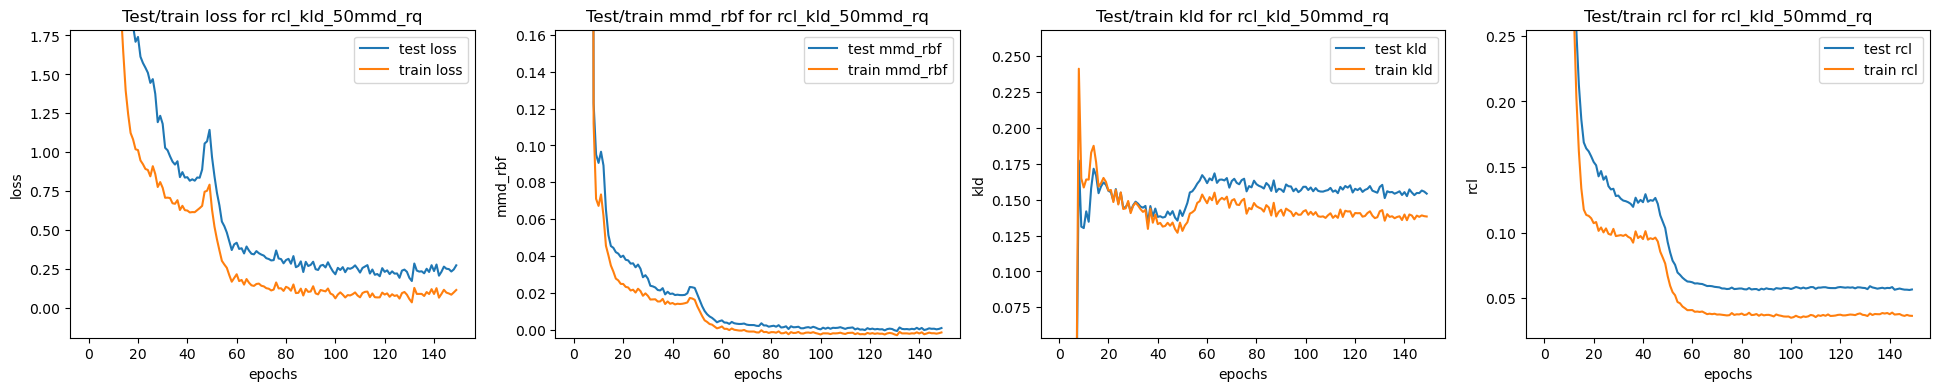

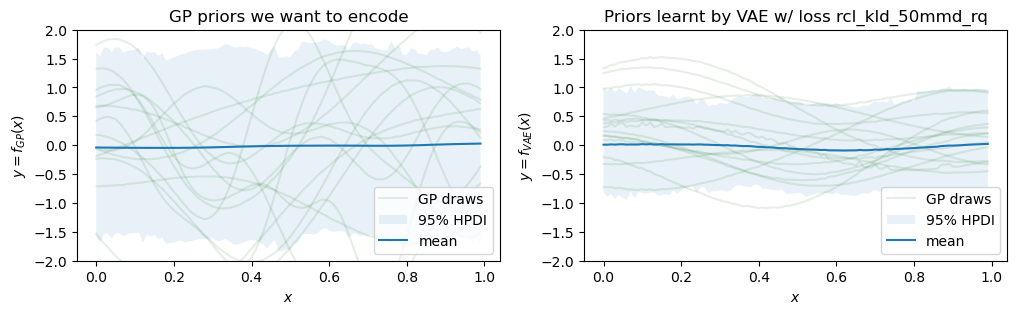

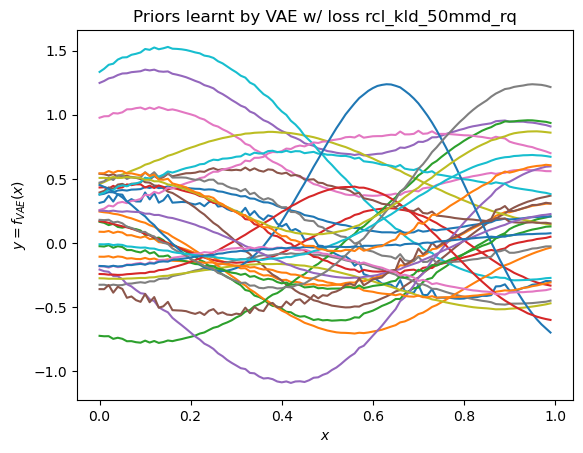

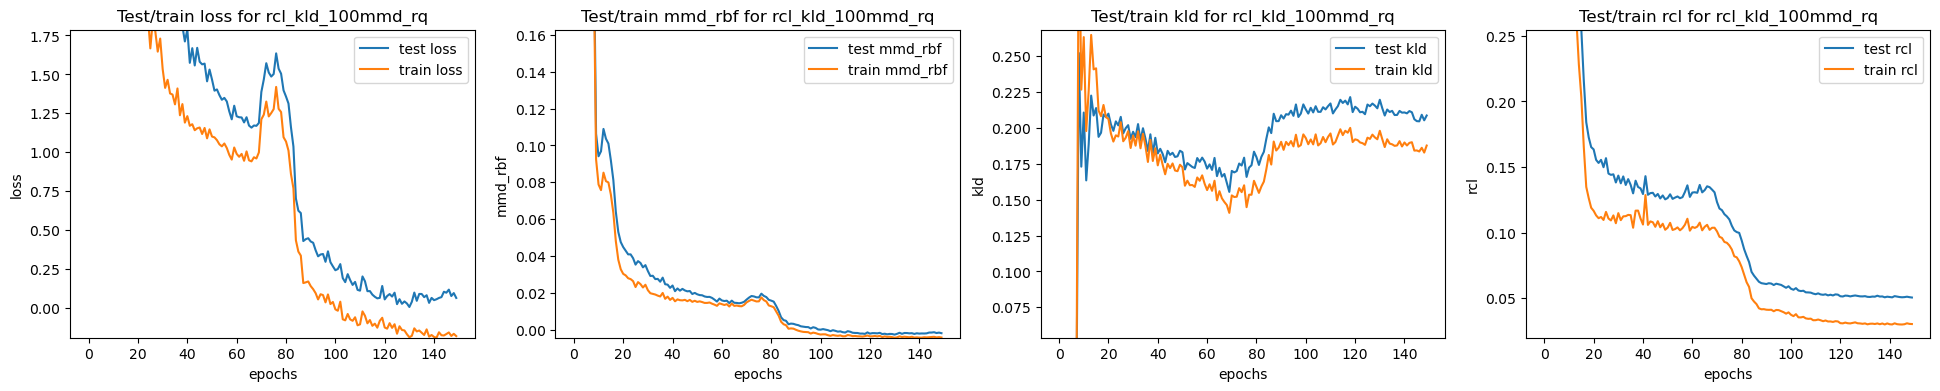

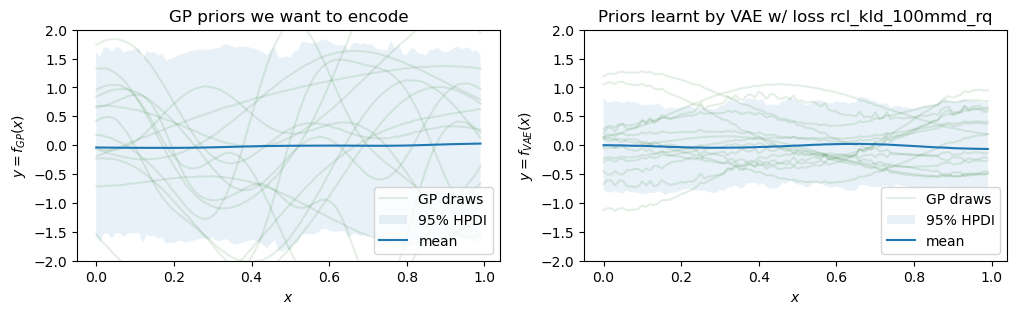

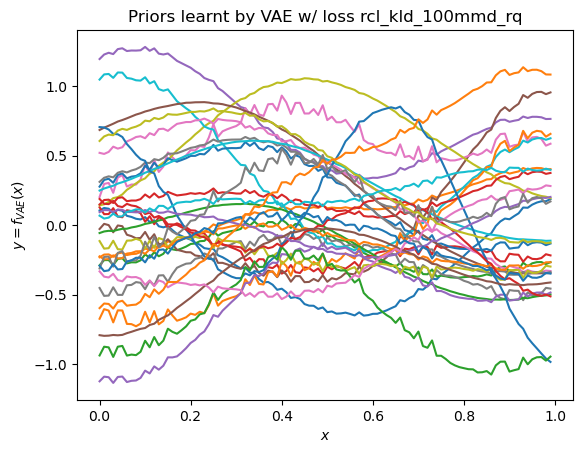

In [13]:
import matplotlib.pyplot as plt
from plotting.plots import plot_training, compare_draws, plot_draws

from reusable.gp import OneDGP
from reusable.vae import vae_sample

from reusable.vae import VAE_Decoder
from reusable.util import load_training_history, gen_file_name, load_training_state, get_decoder_params

rng_key_gp, rng_key_predict = random.split(random.PRNGKey(2))


plot_gp_predictive = Predictive(OneDGP, num_samples=1000)
gp_draws = plot_gp_predictive(rng_key_gp, x=args["x"], gp_kernel = args["gp_kernel"], jitter=1e-5)['y']


to_plot = ["loss", "mmd_rbf", "kld", "rcl"]

ylims = [[0,0], [0,0], [0,0],[0,0]]

flattenned_histories = {}

cutoff = 40

histories = {}
failed = {}
for loss_fn in args["loss_functions"]:

    try: 
        metrics_history = load_training_history("04", gen_file_name("04", args, loss_fn))
        failed[loss_fn] = False
    
    except FileNotFoundError:
        failed[loss_fn] = True
        continue

    histories[loss_fn] = metrics_history

    for key, value in metrics_history.items():
        #print(key, jnp.max(value[cutoff:]))
        if key in flattenned_histories:
            flattenned_histories[key] = jnp.concatenate((flattenned_histories[key], value[cutoff:]), axis=0)
        else:
            flattenned_histories[key] = value[cutoff:] 



for i,t in enumerate(to_plot):
    ylims[i][0] = min(jnp.min(flattenned_histories["test_"+t]), jnp.min(flattenned_histories["train_"+t])) #/scaling_factors[t]
    ylims[i][1] = max(jnp.max(flattenned_histories["test_"+t]), jnp.max(flattenned_histories["train_"+t])) #/scaling_factors[t]

print(histories[loss_fn]["test_"+t].shape)

for loss_fn in args["loss_functions"]:
    if failed[loss_fn]:
        print("Failed to load loss function "+ loss_fn)
        continue
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(24, 4))

    for i,t in enumerate(to_plot):
        plot_training(
            histories[loss_fn]["test_"+t], # / scaling_factors[t],
            histories[loss_fn]["train_"+t], # / scaling_factors[t],
            f"Test/train {t} for " + loss_fn,
            t,
            axs[i],
            ylims = ylims[i]
        )

    dummy_decoder = VAE_Decoder(hidden_dim1=args["hidden_dim1"],   hidden_dim2=args["hidden_dim2"], out_dim=args["n"])
    dummy_params = dummy_decoder.init(random.PRNGKey(0), jnp.ones((args["latent_dim"],)))

    decoder_params = load_training_state("04", gen_file_name("04", args, loss_fn), dummy_params)


    plot_vae_predictive = Predictive(vae_sample, num_samples=1000)
    vae_draws = plot_vae_predictive(
        rng_key_predict,
        hidden_dim1=args["hidden_dim1"],
        hidden_dim2=args["hidden_dim2"],
        latent_dim=args["latent_dim"],
        out_dim=args["n"],
        decoder_params=decoder_params,
    )["f"]
          
    compare_draws(args["x"], gp_draws, vae_draws, "GP priors we want to encode", "Priors learnt by VAE w/ loss " + loss_fn, '$y=f_{GP}(x)$', '$y=f_{VAE}(x)$')

    plot_draws(vae_draws,args["x"], "Priors learnt by VAE w/ loss " + loss_fn, '$y=f_{VAE}(x)$')

        